In [2]:
import sys, os, glob, json, tqdm
root_dir = '/home/gddaslab/mxp140/tcr_project_ultimate'
sys.path.append(root_dir)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, logrank, pearsonr, linregress, mannwhitneyu

In [3]:
full_data = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data-PANPEP.csv', sep=',')
patients = np.unique(full_data['Patient'].values)
dfs = []
for patient_id in patients[:]:
    print(f'Processing patient {patient_id}...')
    data_dir = "/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/PANPEP"
    filepaths = os.path.join(data_dir, patient_id, f"{patient_id}_region*.csv")
    files = glob.glob(filepaths)
    sorted_files = sorted(files, key=lambda x: int(x.split("region")[1].split(".")[0]))
    region_labels = [f'region{file.split("region")[1].split("_")[0][:-4]}' for file in sorted_files]
    # print(region_labels)
    data = []
    colors = ["blue", "orange", "green", "red"]

    for file in sorted_files:
        df = pd.read_csv(file, sep=",",)
        clone_count_values = df['counts'].values
        data.append(clone_count_values)

    #Add combined data at the end of each list wherever necessary
    combined_data = full_data[full_data['Patient']==patient_id]
    combined_clone_count_values = combined_data['counts'].values
    combined_clone_count_values = combined_clone_count_values[combined_clone_count_values>=1]
    data = data + [combined_clone_count_values]
    colors = colors + ["black"]
    region_labels = region_labels + ['combined']
    
    # Create a DataFrame for seaborn
    df_list = []
    for i in range(len(data)):
        df_temp = pd.DataFrame(data[i], columns=['counts'])
        df_temp['patient'] = [patient_id + '-' + region_labels[i]]*len(data[i])
        df_list.append(df_temp)
    df = pd.concat(df_list)
    dfs.append(df)

Processing patient BrMET008...
Processing patient BrMET009...
Processing patient BrMET010...
Processing patient BrMET018...
Processing patient BrMET019...
Processing patient BrMET025...
Processing patient BrMET027...
Processing patient BrMET028...
Processing patient GBM032...
Processing patient GBM052...
Processing patient GBM055...
Processing patient GBM056...
Processing patient GBM059...
Processing patient GBM062...
Processing patient GBM063...
Processing patient GBM064...
Processing patient GBM070...
Processing patient GBM074...
Processing patient GBM079...


In [4]:
all_dfs = pd.concat(dfs)
all_dfs['GBM'] = all_dfs["patient"].str.contains("GBM")
all_dfs.head(10)

,counts,patient,GBM
0,1,BrMET008-region1,False
1,1,BrMET008-region1,False
2,1,BrMET008-region1,False
3,2,BrMET008-region1,False
4,2,BrMET008-region1,False
5,1,BrMET008-region1,False
6,1,BrMET008-region1,False
7,1,BrMET008-region1,False
8,1,BrMET008-region1,False
9,1,BrMET008-region1,False


LogRankResult(statistic=np.float64(-37.15119676459278), pvalue=np.float64(4.1932538459849365e-302))


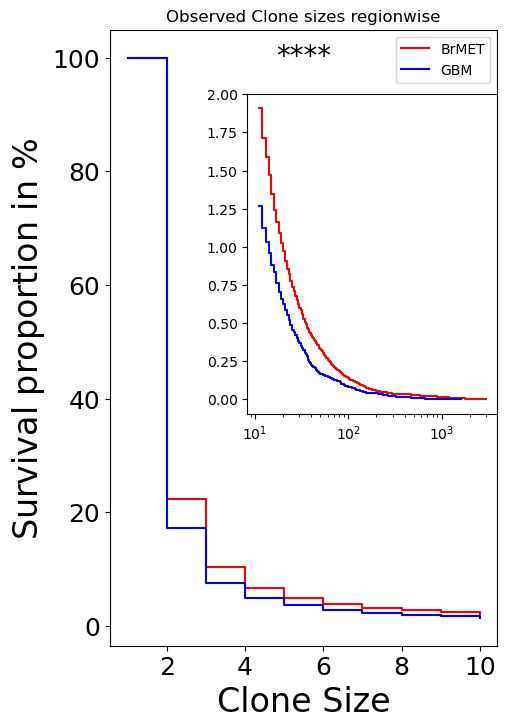

In [5]:
brmets, gbms = all_dfs[(all_dfs['patient'].str.contains('BrMET')) & (~all_dfs['patient'].str.contains('combined'))], all_dfs[(all_dfs['patient'].str.contains('GBM')) & (~all_dfs['patient'].str.contains('combined'))]
brmet_config, gbm_config = brmets['counts'].values, gbms['counts'].values
log_rank_test = logrank(brmet_config, gbm_config)
print(f'{log_rank_test}')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 8))
labels = ['BrMET', 'GBM']
colors = ['red', 'blue']
mask_value = 10
for i, config in enumerate([brmet_config, gbm_config]):
    x, y0 = np.unique(config, return_counts=True)
    y = (np.cumsum(y0[::-1])[::-1]) / sum(y0)
    mask=x<=mask_value
    ax.step(x[mask], y[mask]*100, where='post', label=labels[i], color=colors[i])
ax.legend(loc='best')
ax.set_xlabel('Clone Size', fontsize=24)
ax.set_ylabel(r'Survival proportion in $\%$', fontsize=24)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=18)

inset_ax = fig.add_axes([0.4, 0.4, 0.5, 0.4])
for i, config in enumerate([brmet_config, gbm_config]):
    x, y0 = np.unique(config, return_counts=True)
    y = (np.cumsum(y0[::-1])[::-1]) / sum(y0)
    mask = x > mask_value
    inset_ax.step(x[mask], y[mask] * 100, where='post', label=labels[i], color=colors[i])
inset_ax.set_xscale('log')
# inset_ax.set_yscale('log')

ax.text(0.5, 0.98, '****', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', horizontalalignment='center')
ax.set_title(f'Observed Clone sizes regionwise')
plt.show()

In [7]:
a = np.unique(brmets['counts'].values, return_counts=True)
df = pd.DataFrame({'clone size':a[0], 'counts':a[1]})
print((np.sum(df[df['clone size']>100]['counts'].values)/np.sum(df['counts'].values))*100)

0.13730523550832785


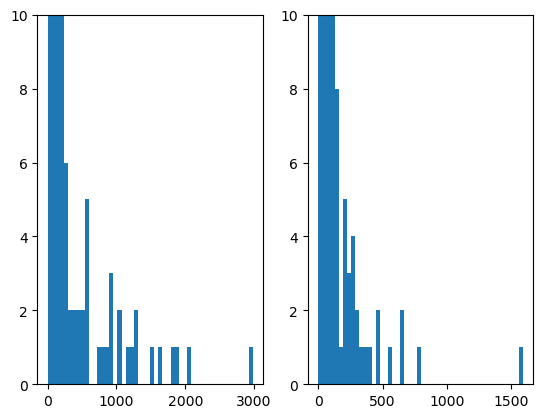

In [23]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(brmets['counts'].values, bins=50)
ax[0].set_ylim(0, 10)
ax[1].hist(gbms['counts'].values, bins=50)
ax[1].set_ylim(0, 10)
plt.show()

Mann-Whitney U test:

In [143]:
req_all_dfs = all_dfs[~all_dfs['patient'].str.contains('combined')].iloc[:, :2]
brmet_data = req_all_dfs[req_all_dfs['patient'].str.contains('BrMET')]
gbm_data = req_all_dfs[req_all_dfs['patient'].str.contains('GBM')]
brmet_patients = brmet_data['patient'].unique()
gbm_patients = gbm_data['patient'].unique()

p_values_original = {}
for i, patient1 in tqdm.tqdm(enumerate(brmet_patients)):
    data1 = req_all_dfs[req_all_dfs['patient'] == patient1]['counts']
    for j, patient2 in enumerate(gbm_patients):
        data2 = req_all_dfs[req_all_dfs['patient'] == patient2]['counts']
        _, p_value = mannwhitneyu(data1, data2, alternative='greater')
        p_values_original[f'{patient1}-{patient2}'] = p_value
mean_p_values_original = np.mean(list(p_values_original.values()))

patient_name_in_original_order = req_all_dfs['patient'].unique()
data_in_order = [req_all_dfs[req_all_dfs['patient']==patient_id]['counts'].values for patient_id in patient_name_in_original_order]

# Create multiple permutations
n_permutations = 1000  # You can adjust this number
mean_p_values_from_permuted_data = []
for i in tqdm.tqdm(range(n_permutations)):
    p_values_permutations = {}
    # Create a mapping dictionary for this permutation
    permuted_patients = np.random.permutation(patient_name_in_original_order)
    for i, patient1 in enumerate(brmet_patients):
        patient1_new_location = np.where(permuted_patients==patient1)[0][0]
        data1 = data_in_order[patient1_new_location]
        for j, patient2 in enumerate(gbm_patients):
            patient2_new_location = np.where(permuted_patients==patient2)[0][0]
            data2 = data_in_order[patient2_new_location]
            _, p_value = mannwhitneyu(data1, data2, alternative='greater')
            p_values_permutations[f'{patient1}-{patient2}'] = p_value
    mean_p_values_from_permuted_data.append(np.mean(list(p_values_permutations.values())))
print(f'{(np.sum(mean_p_values_from_permuted_data > mean_p_values_original)/n_permutations)*100:.2f}% of the p-values from permutations are larger than the mean p-value obtained in the case of original data.')

25it [00:07,  3.38it/s]
100%|██████████| 1000/1000 [08:36<00:00,  1.94it/s]

97.10% of the p-values from permutations are larger than the mean p-value obtained in the case of original data.


# POOLED

LogRankResult(statistic=np.float64(-205.03904222533953), pvalue=np.float64(0.0))


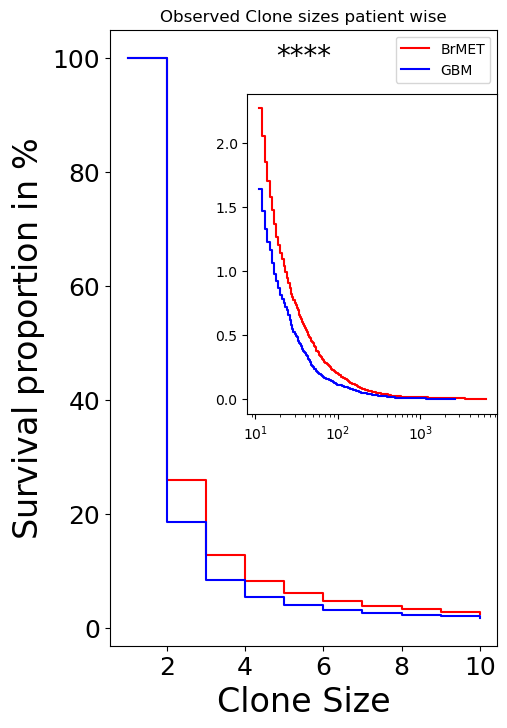

In [5]:
brmets, gbms = all_dfs[(all_dfs['patient'].str.contains('BrMET')) & (all_dfs['patient'].str.contains('combined'))], all_dfs[(all_dfs['patient'].str.contains('GBM')) & (all_dfs['patient'].str.contains('combined'))]
brmet_config, gbm_config = brmets['counts'].values, gbms['counts'].values
log_rank_test = logrank(brmet_config, gbm_config)
print(f'{log_rank_test}')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 8))
labels = ['BrMET', 'GBM']
colors = ['red', 'blue']
mask_value = 10
for i, config in enumerate([brmet_config, gbm_config]):
    x, y0 = np.unique(config, return_counts=True)
    y = (np.cumsum(y0[::-1])[::-1]) / sum(y0)
    mask = x<=mask_value
    ax.step(x[mask], y[mask]*100, where='post', label=labels[i], color=colors[i])
ax.legend(loc='best')
ax.set_xlabel('Clone Size', fontsize=24)
ax.set_ylabel(r'Survival proportion in $\%$', fontsize=24)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=18)

inset_ax = fig.add_axes([0.4, 0.4, 0.5, 0.4])
for i, config in enumerate([brmet_config, gbm_config]):
    x, y0 = np.unique(config, return_counts=True)
    y = (np.cumsum(y0[::-1])[::-1]) / sum(y0)
    mask = x > mask_value
    inset_ax.step(x[mask], y[mask] * 100, where='post', label=labels[i], color=colors[i])
inset_ax.set_xscale('log')
# inset_ax.set_yscale('log')
ax.text(0.5, 0.98, '****', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', horizontalalignment='center')
ax.set_title(f'Observed Clone sizes patient wise')
plt.show()

In [135]:
######################### U-test #############################################
req_all_dfs = all_dfs[all_dfs['patient'].str.contains('combined')].iloc[:, :2]
brmet_data = req_all_dfs[req_all_dfs['patient'].str.contains('BrMET')]
gbm_data = req_all_dfs[req_all_dfs['patient'].str.contains('GBM')]
brmet_patients = brmet_data['patient'].unique()
gbm_patients = gbm_data['patient'].unique()

p_values_original = {}
for i, patient1 in tqdm.tqdm(enumerate(brmet_patients)):
    data1 = req_all_dfs[req_all_dfs['patient'] == patient1]['counts']
    for j, patient2 in enumerate(gbm_patients):
        data2 = req_all_dfs[req_all_dfs['patient'] == patient2]['counts']
        _, p_value = mannwhitneyu(data1, data2, alternative='greater')
        p_values_original[f'{patient1}-{patient2}'] = p_value
mean_p_values_original = np.mean(list(p_values_original.values()))

patient_name_in_original_order = req_all_dfs['patient'].unique()
data_in_order = [req_all_dfs[req_all_dfs['patient']==patient_id]['counts'].values for patient_id in patient_name_in_original_order]

# Create multiple permutations
n_permutations = 500  # You can adjust this number
mean_p_values_from_permuted_data = []
for i in tqdm.tqdm(range(n_permutations)):
    p_values_permutations = {}
    # Create a mapping dictionary for this permutation
    permuted_patients = np.random.permutation(patient_name_in_original_order)
    for i, patient1 in enumerate(brmet_patients):
        patient1_new_location = np.where(permuted_patients==patient1)[0][0]
        data1 = data_in_order[patient1_new_location]
        for j, patient2 in enumerate(gbm_patients):
            patient2_new_location = np.where(permuted_patients==patient2)[0][0]
            data2 = data_in_order[patient2_new_location]
            _, p_value = mannwhitneyu(data1, data2, alternative='greater')
            p_values_permutations[f'{patient1}-{patient2}'] = p_value
    mean_p_values_from_permuted_data.append(np.mean(list(p_values_permutations.values())))
print(f'{(np.sum(mean_p_values_from_permuted_data > mean_p_values_original)/n_permutations)*100:.2f}% of the p-values from permutations are larger than the mean p-value obtained in the case of original data.')

8it [00:01,  5.77it/s]
100%|██████████| 500/500 [00:47<00:00, 10.53it/s]

98.20% of the p-values from permutations are larger than the mean p-value obtained in the case of original data.


In [22]:
print('MEAN clone size =>', 'BrMET:', brmets['counts'].mean(), ' GBM:', gbms['counts'].mean())

MEAN clone size => BrMET: 2.82819942386127  GBM: 2.074367774566474


In [23]:
a = np.unique(gbms['counts'].values, return_counts=True)
df = pd.DataFrame({'clone size':a[0], 'counts':a[1]})
print((np.sum(df[df['clone size']>100]['counts'].values)/np.sum(df['counts'].values))*100)

0.1119942196531792


In [6]:
with open(f"/home/gddaslab/mxp140/TCR_PROJECT_OLD/tcr_project_git/data/cell_popn.json", 'r+') as f:
    cell_popn = json.load(f)
    macrophages = cell_popn['macrophages']

In [7]:
macrophages_intensity = {}
for key in macrophages.keys():
    for sub_key in macrophages[key].keys():
        list_ = macrophages[key][sub_key]
        if key not in macrophages_intensity:
            macrophages_intensity[key] = {}
        macrophages_intensity[key]['region'+sub_key] = 0.299*list_[0] + 0.587*list_[1] + 0.114*list_[2]

In [8]:
macrophage_df = pd.DataFrame({f"{patient}-{region}": values 
            for patient, regions in macrophages_intensity.items()
            for region, values in regions.items()}, 
            index=['intensity']).transpose().reset_index().rename(columns={'index': 'patient'})
macrophage_df

,patient,intensity
0,BrMET008-region1,215.706
1,BrMET008-region2,220.368
2,BrMET008-region3,218.510
3,BrMET008-region4,241.199
4,BrMET009-region1,156.003
...,...,...
61,GBM074-region2,192.861
62,GBM074-region3,191.274
63,GBM079-region1,201.746
64,GBM079-region2,187.655


In [9]:
full_data = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data-PANPEP.csv', sep=',')
patients = np.unique(full_data['Patient'].values)
dfs = []
for patient_id in patients[:]:
    # print(f'Processing patient {patient_id}...')
    data_dir = "/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/PANPEP"
    filepaths = os.path.join(data_dir, patient_id, f"{patient_id}_region*.csv")
    files = glob.glob(filepaths)
    sorted_files = sorted(files, key=lambda x: int(x.split("region")[1].split(".")[0]))
    region_labels = [f'region{file.split("region")[1].split("_")[0][:-4]}' for file in sorted_files]
    # print(region_labels)
    data = []
    colors = ["blue", "orange", "green", "red"]

    for file in sorted_files:
        df = pd.read_csv(file, sep=",",)
        clone_count_values = df['counts'].values
        data.append(clone_count_values)

    #Add combined data at the end of each list wherever necessary
    combined_data = full_data[full_data['Patient']==patient_id]
    combined_clone_count_values = combined_data['counts'].values
    data = data + [combined_clone_count_values]
    colors = colors + ["black"]
    region_labels = region_labels + ['combined']
    
    # Create a DataFrame for seaborn
    df_list = []
    for i in range(len(data)):
        df_temp = pd.DataFrame(data[i], columns=['counts'])
        df_temp['patient'] = [patient_id + '-' + region_labels[i]]*len(data[i])
        df_list.append(df_temp)
    df = pd.concat(df_list)
    dfs.append(df)

In [10]:
all_dfs = pd.concat(dfs, ignore_index=True)
filtered_dfs = all_dfs[~all_dfs['patient'].str.contains('combined')]
result = filtered_dfs.groupby('patient')['counts'].agg('mean').reset_index()
print(result.head())

            patient    counts
0  BrMET008-region1  1.876147
1  BrMET008-region2  1.459184
2  BrMET008-region3  1.205128
3  BrMET008-region4  1.438202
4  BrMET009-region1  3.296365


In [11]:
req_df = result.merge(macrophage_df, how='inner', on='patient')
print(req_df.head())

            patient    counts  intensity
0  BrMET008-region1  1.876147    215.706
1  BrMET008-region2  1.459184    220.368
2  BrMET008-region3  1.205128    218.510
3  BrMET008-region4  1.438202    241.199
4  BrMET009-region1  3.296365    156.003


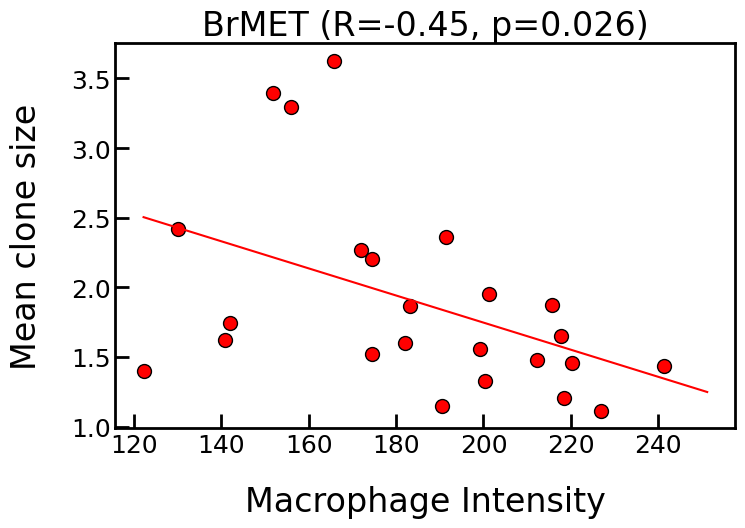

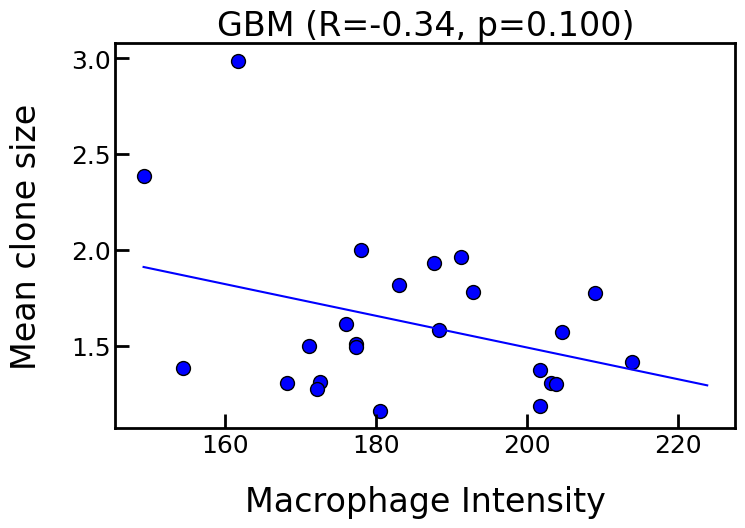

In [23]:
x_values = req_df['intensity'].values
y_values = req_df['counts'].values

brmet_mask = req_df['patient'].str.contains('BrMET')
gbm_mask = req_df['patient'].str.contains('GBM')

corr_all = pearsonr(x_values, y_values)
corr_brmet = pearsonr(x_values[brmet_mask], y_values[brmet_mask])
corr_gbm = pearsonr(x_values[gbm_mask], y_values[gbm_mask])

mask = [brmet_mask, gbm_mask]
colors = ['red', 'blue']
titles = [f'BrMET (R={corr_brmet.statistic:.2f}, p={corr_brmet.pvalue:.3f})', f'GBM (R={corr_gbm.statistic:.2f}, p={corr_gbm.pvalue:.3f})']
for i in range(2):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
    x = x_values[mask[i]]
    y = y_values[mask[i]]
    ax.scatter(x, y, s=100, color=colors[i], edgecolor='black', alpha=1)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    x_range = np.linspace(min(x), max(x)+10, 1000)
    ax.plot(x_range, slope * x_range + intercept, color=colors[i], )
    ax.set_xlabel('Macrophage Intensity', fontsize=24)
    ax.set_ylabel(r'Mean clone size', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=16)
    xtick_labels, ytick_labels = ax.get_xticklabels(), ax.get_yticklabels()
    for label in xtick_labels + ytick_labels:
        label.set_fontsize(24)
    ax.tick_params(
        axis="x", which="major", direction="in", length=10, width=2, labelsize=18
    )
    ax.tick_params(
        axis="x", which="minor", direction="in", length=5, width=2, labelsize=18
    )
    ax.tick_params(
        axis="y", which="major", direction="in", length=10, width=2, labelsize=18
    )
    ax.tick_params(
        axis="y", which="minor", direction="in", length=5, width=2, labelsize=18
    )
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["top"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.yaxis.labelpad = 20
    ax.xaxis.labelpad = 20
    ax.set_title(titles[i], fontsize=24)
    plt.show()